In [216]:
#!pip install -U segmentation-models-pytorch

import libraries

In [217]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from albumentations import Compose, Resize
from albumentations.pytorch import ToTensorV2
from torchmetrics.classification import BinaryJaccardIndex
from tqdm import tqdm
import torch.nn as nn
from torchinfo import summary
from torchvision import models
from PIL import Image
from torchvision import transforms

mount google drive

In [218]:
#from google.colab import drive
#drive.mount('/content/drive')

function to map polygon to image masks - training data

In [219]:
images_dir = "./dataset/train/images"
labels_dir = "./dataset/train/labels"
masks_dir = "./dataset/train/output_masks"
os.makedirs(masks_dir, exist_ok=True)

for img_file in os.listdir(images_dir):
    if not img_file.endswith(('.jpg', '.png')):
        continue
    img_path = os.path.join(images_dir, img_file)
    label_path = os.path.join(labels_dir, os.path.splitext(img_file)[0] + '.txt')
    mask_path = os.path.join(masks_dir, os.path.splitext(img_file)[0] + '.png')
    img = cv2.imread(img_path)
    if img is None:
        print(f"Could not load image {img_path}")
        continue
    h, w = img.shape[:2]
    mask = np.zeros((h, w), dtype=np.uint8)
    if os.path.exists(label_path):
        with open(label_path) as f:
            for line in f:
                items = list(map(float, line.strip().split()))
                cls = int(items[0]) + 1  # background=0, class 0=1, etc
                points = np.array(items[1:]).reshape(-1, 2)
                points[:, 0] *= w
                points[:, 1] *= h
                points = points.astype(np.int32)
                cv2.fillPoly(mask, [points], cls)
    cv2.imwrite(mask_path, mask)

function to map polygon to image masks - validation data

In [220]:
images_dir = "./dataset/valid/images"
labels_dir = "./dataset/valid/labels"
masks_dir = "./dataset/valid/output_masks"
os.makedirs(masks_dir, exist_ok=True)

for img_file in os.listdir(images_dir):
    if not img_file.endswith(('.jpg', '.png')):
        continue
    img_path = os.path.join(images_dir, img_file)
    label_path = os.path.join(labels_dir, os.path.splitext(img_file)[0] + '.txt')
    mask_path = os.path.join(masks_dir, os.path.splitext(img_file)[0] + '.png')
    img = cv2.imread(img_path)
    if img is None:
        print(f"Could not load image {img_path}")
        continue
    h, w = img.shape[:2]
    mask = np.zeros((h, w), dtype=np.uint8)
    if os.path.exists(label_path):
        with open(label_path) as f:
            for line in f:
                items = list(map(float, line.strip().split()))
                cls = int(items[0]) + 1
                points = np.array(items[1:]).reshape(-1, 2)
                points[:, 0] *= w
                points[:, 1] *= h
                points = points.astype(np.int32)
                cv2.fillPoly(mask, [points], cls)
    cv2.imwrite(mask_path, mask)

show example data

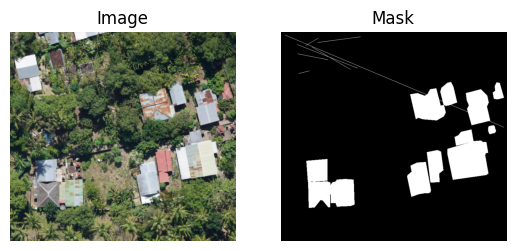

In [221]:
img = cv2.imread('./dataset/valid/images/Screenshot-2025-03-01-224236_png.rf.2b5295a45ee7ab530f027f63eafca4d1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = cv2.imread('./dataset/valid/output_masks/Screenshot-2025-03-01-224236_png.rf.2b5295a45ee7ab530f027f63eafca4d1.png', cv2.IMREAD_GRAYSCALE)

plt.subplot(1,2,1); plt.imshow(img); plt.axis('off'); plt.title('Image')
plt.subplot(1,2,2); plt.imshow(mask, cmap='gray'); plt.axis('off'); plt.title('Mask')
plt.show()

segmentation dataset

In [222]:
class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.files = [f for f in os.listdir(images_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_name = self.files[idx]
        img_path = os.path.join(self.images_dir, img_name)

        mask_name = os.path.splitext(img_name)[0] + '.png'
        mask_path = os.path.join(self.masks_dir, mask_name)

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if mask is None:
            raise FileNotFoundError(f"Mask file not found or could not be opened: {mask_path}")

        if self.transform is not None:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        image = torch.tensor(image, dtype=torch.float).permute(2,0,1)/255.0
        mask = torch.tensor(mask, dtype=torch.long)
        return image, mask

data load

In [223]:
train_transform = Compose([
    Resize(256, 256),
])

valid_transform = Compose([
    Resize(256, 256),
])

train_dataset = SegmentationDataset(
    images_dir='./dataset/train/images',
    masks_dir='./dataset/train/output_masks',
    transform=train_transform
)
valid_dataset = SegmentationDataset(
    images_dir='./dataset/valid/images',
    masks_dir='./dataset/valid/output_masks',
    transform=valid_transform
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)

dice loss

In [224]:
import torch.nn as nn

class DiceLoss(nn.Module):
    def __init__(self, smooth=1):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        logits = torch.sigmoid(logits)
        logits = logits.view(-1)
        targets = targets.view(-1)

        intersection = (logits * targets).sum()
        dice = (2. * intersection + self.smooth) / (logits.sum() + targets.sum() + self.smooth)
        return 1 - dice

define model

In [225]:
model = smp.UnetPlusPlus(
    encoder_name="resnet18",        
    encoder_weights="imagenet",     
    in_channels=3,
    classes=1,
    decoder_dropout=0.2                      
)

loss_fn = lambda logits, targets: 0.5 * nn.BCEWithLogitsLoss()(logits, targets) + 0.5 * DiceLoss()(logits, targets) 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

c:\Users\hg\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\hg\.cache\huggingface\hub\models--smp-hub--resnet18.imagenet. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [226]:
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer,
#     mode='min',
#     factor=0.5,    
#     patience=3,          
# )

train the data

In [227]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
epochs_input = 20


jaccard = BinaryJaccardIndex().to(device)
best_score = 0.0

for epoch in range(epochs_input):
    print(f"\nEpoch [{epoch+1}/{epochs_input}]")

    # --- Training ---
    model.train()
    train_loss = 0.0
    for images, masks in tqdm(train_loader, desc="Training", leave=False):
        try:
            images = images.to(device)
            masks = masks.unsqueeze(1).float().to(device)

            optimizer.zero_grad()
            outputs = model(images)   
            loss = loss_fn(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
        except Exception as e:
            print(f"Error in training batch: {e}")

    avg_train_loss = train_loss / len(train_loader)
    print(f"Training Loss: {avg_train_loss:.4f}")

    model.eval()
    jaccard.reset()
    val_loss = 0.0

    with torch.no_grad():
        for images, masks in tqdm(valid_loader, desc="Validating", leave=False):
            try:
                images = images.to(device)
                masks = masks.unsqueeze(1).float().to(device)

                outputs = model(images)
                loss = loss_fn(outputs, masks)
                val_loss += loss.item()

                preds = torch.sigmoid(outputs)
                preds = (preds > 0.5).float()
                jaccard.update(preds, masks.int())

            except Exception as e:
                print(f"Error in validation batch: {e}")

    avg_val_loss = val_loss / len(valid_loader)
    epoch_iou = jaccard.compute().item()
    print(f"Validation Loss: {avg_val_loss:.4f} | IoU: {epoch_iou:.4f}")
    # scheduler.step(avg_val_loss)

    if epoch_iou > best_score:
        best_score = epoch_iou
        torch.save(model.state_dict(), "best_model.pth")
        print("✅ Best model saved.")


Epoch [1/20]


Training Loss: 0.3309


Validation Loss: 0.4384 | IoU: 0.5709
✅ Best model saved.

Epoch [2/20]


Training Loss: 0.1733


Validation Loss: 0.3400 | IoU: 0.5979
✅ Best model saved.

Epoch [3/20]


Training Loss: 0.1307


Validation Loss: 0.3232 | IoU: 0.6197
✅ Best model saved.

Epoch [4/20]


Training Loss: 0.1012


Validation Loss: 0.3143 | IoU: 0.6343
✅ Best model saved.

Epoch [5/20]


Training Loss: 0.0951


Validation Loss: 0.3348 | IoU: 0.6276

Epoch [6/20]


Training Loss: 0.0943


Validation Loss: 0.3302 | IoU: 0.6128

Epoch [7/20]


Training Loss: 0.0780


Validation Loss: 0.3208 | IoU: 0.6358
✅ Best model saved.

Epoch [8/20]


Training Loss: 0.0765


Validation Loss: 0.3643 | IoU: 0.6366
✅ Best model saved.

Epoch [9/20]


Training Loss: 0.0681


Validation Loss: 0.3403 | IoU: 0.6411
✅ Best model saved.

Epoch [10/20]


Training Loss: 0.0584


Validation Loss: 0.3651 | IoU: 0.6443
✅ Best model saved.

Epoch [11/20]


Training Loss: 0.0536


Validation Loss: 0.3304 | IoU: 0.6420

Epoch [12/20]


Training Loss: 0.0580


Validation Loss: 0.3736 | IoU: 0.6262

Epoch [13/20]


Training Loss: 0.0657


Validation Loss: 0.2949 | IoU: 0.6418

Epoch [14/20]


Training Loss: 0.0619


Validation Loss: 0.3572 | IoU: 0.6473
✅ Best model saved.

Epoch [15/20]


Training Loss: 0.0526


Validation Loss: 0.3187 | IoU: 0.6348

Epoch [16/20]


Training Loss: 0.0484


Validation Loss: 0.3795 | IoU: 0.6321

Epoch [17/20]


Training Loss: 0.0568


Validation Loss: 0.4462 | IoU: 0.6256

Epoch [18/20]


Training Loss: 0.0544


Validation Loss: 0.3415 | IoU: 0.6460

Epoch [19/20]


Training Loss: 0.0450


Validation Loss: 0.3730 | IoU: 0.6450

Epoch [20/20]


Training Loss: 0.0408


Validation Loss: 0.3580 | IoU: 0.6476
✅ Best model saved.


In [228]:
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)
model.eval()

UnetPlusPlus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [229]:
import os
import cv2
import numpy as np

images_dir = "./dataset/test/images"
labels_dir = "./dataset/test/labels"
masks_dir = "./dataset/test/output_masks"
os.makedirs(masks_dir, exist_ok=True)

for img_file in os.listdir(images_dir):
    if not img_file.endswith(('.jpg', '.png')):
        continue

    img_path = os.path.join(images_dir, img_file)
    label_path = os.path.join(labels_dir, os.path.splitext(img_file)[0] + '.txt')
    mask_path = os.path.join(masks_dir, os.path.splitext(img_file)[0] + '.png')

    img = cv2.imread(img_path)
    if img is None:
        print(f"Could not load image {img_path}")
        continue

    h, w = img.shape[:2]
    mask = np.zeros((h, w), dtype=np.uint8)

    if os.path.exists(label_path):
        with open(label_path) as f:
            for line in f:
                items = list(map(float, line.strip().split()))
                cls = int(items[0]) + 1
                points = np.array(items[1:]).reshape(-1, 2)
                points[:, 0] *= w
                points[:, 1] *= h
                points = points.astype(np.int32)
                cv2.fillPoly(mask, [points], cls)

    cv2.imwrite(mask_path, mask)


In [230]:
from torch.utils.data import Dataset
import numpy as np
from PIL import Image
from torchvision import transforms as T
import os

class TestSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, os.path.splitext(self.images[idx])[0] + '.png')

        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"))

        if self.transform:
            augmented = self.transform(image=np.array(image), mask=np.array(mask))
            image = augmented["image"]
            mask = augmented["mask"]
        else:
            image = T.ToTensor()(image)
            mask = torch.from_numpy(np.array(mask)).unsqueeze(0).float() / 255.0

        return image, mask

    def __len__(self):
        return len(self.images)


In [231]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
test_transform = A.Compose([
    A.PadIfNeeded(
        min_height=None,
        min_width=None,
        pad_height_divisor=32,
        pad_width_divisor=32,
        border_mode=0,
        value=0,
        mask_value=0
    ),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])



C:\Users\hg\AppData\Local\Temp\ipykernel_11964\4010001925.py:4: UserWarning: Argument(s) 'value, mask_value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(


In [232]:
from torch.utils.data import DataLoader
import torch
import segmentation_models_pytorch as smp

# Load model
model = smp.UnetPlusPlus(
    encoder_name="resnet18",
    encoder_weights=None,
    in_channels=3,
    classes=1
)
model.load_state_dict(torch.load("best_model.pth", map_location="cpu"))
model.eval().to(device)

# Load test set
test_dataset = TestSegmentationDataset(
    image_dir="./dataset/test/images",
    mask_dir="./dataset/test/output_masks",
    transform=test_transform
)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Evaluate
from torchmetrics.classification import BinaryJaccardIndex

jaccard = BinaryJaccardIndex().to(device)
model.eval()
jaccard.reset()

with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.unsqueeze(1).float().to(device)

        outputs = model(images)
        preds = torch.sigmoid(outputs)
        preds = (preds > 0.5).float()
        jaccard.update(preds, masks.int())

test_iou = jaccard.compute().item()
print(f"✅ Test IoU: {test_iou:.4f}")


✅ Test IoU: 0.6175


In [233]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# Add denormalization function
def denormalize(image_tensor, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return (image_tensor * std + mean).clamp(0, 1)

def visualize_prediction(model, test_loader, device, num_samples=5):
    model.eval()
    model.to(device)

    count = 0
    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).float()

            for i in range(images.size(0)):
                # Denormalize and convert to numpy
                img_tensor = images[i].cpu()
                img_denorm = denormalize(img_tensor, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                image_np = img_denorm.permute(1, 2, 0).numpy()

                mask_np = masks[i].cpu().squeeze().numpy()
                pred_np = preds[i].cpu().squeeze().numpy()

                # Ensure 2D for mask and prediction
                if mask_np.ndim != 2:
                    mask_np = mask_np[0]
                if pred_np.ndim != 2:
                    pred_np = pred_np[0]

                plt.figure(figsize=(12, 4))

                plt.subplot(1, 3, 1)
                plt.title("Original Image")
                plt.imshow(image_np)
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.title("Ground Truth")
                plt.imshow(mask_np, cmap='gray')
                plt.axis('off')

                plt.subplot(1, 3, 3)
                plt.title("Prediction")
                plt.imshow(pred_np, cmap='gray')
                plt.axis('off')

                plt.tight_layout()
                plt.show()

                count += 1
                if count >= num_samples:
                    return


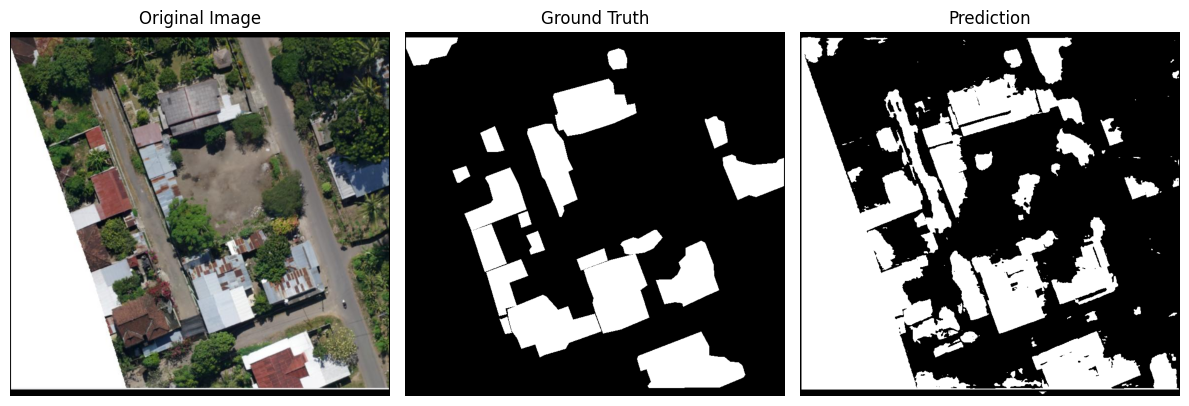

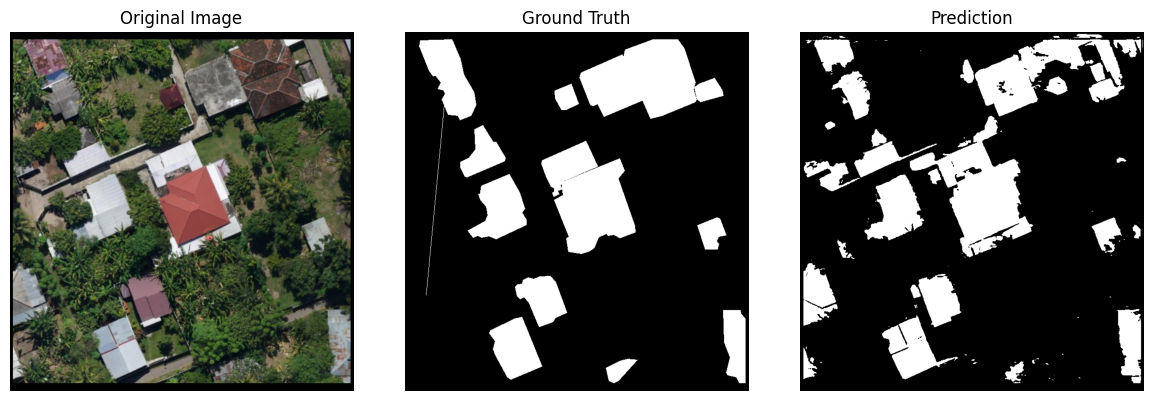

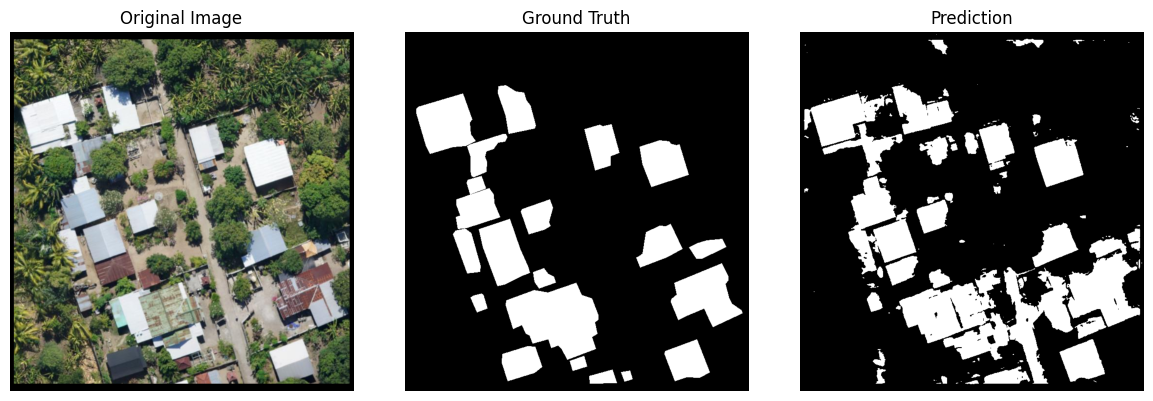

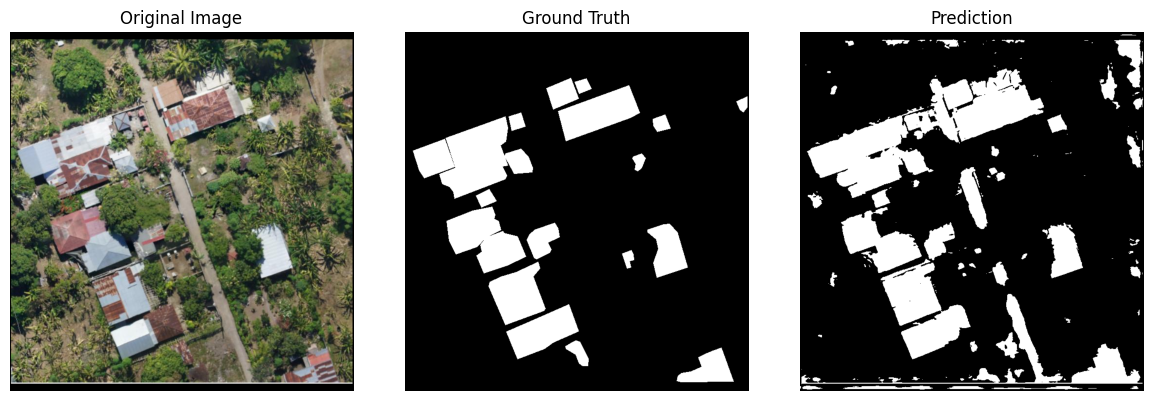

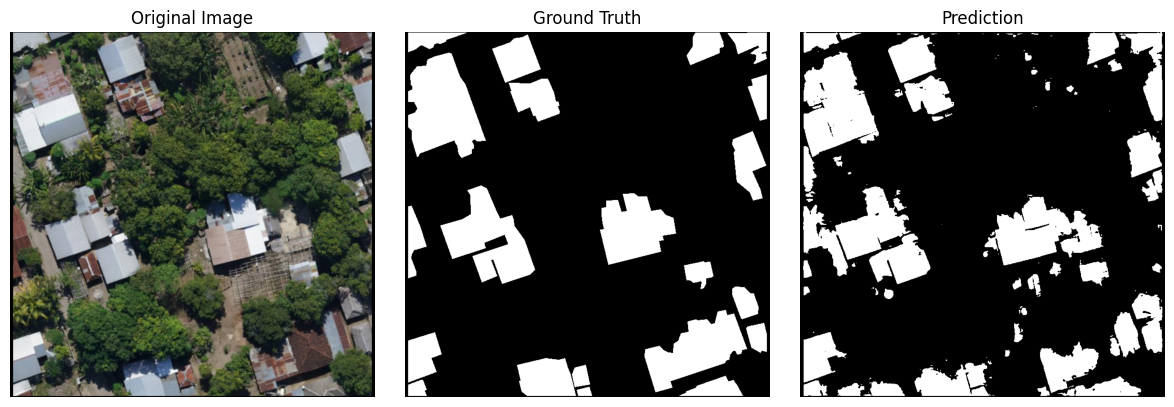

In [234]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
visualize_prediction(model, test_loader, device, num_samples=5)
